# Chapter 13: Standardization and the parametric g-formula

> In this chapter we describe how to use standardization to estimate the average causal effect of smoking cessation on body weight gain.

- 13.1 Standardization as an alternative to IP weighting
- 13.2 Estimating the mean outcome via modeling
- 13.3 Standardizing the mean outcome to the confounder distribution
- 13.4 IP weighting or standardization?
- 13.5 How seriously do we take our estimates?

## Functions

In [1]:
import pandas as pd

raw_cont_vars = ["age", "wt71", "smokeintensity", "smokeyrs"]
cat_vars = ["sex", "race", "education", "exercise", "active"]

def add_raw_quadratics(df, varnames):
    for var in varnames:
        df[f"{var}_sq"] = df[var] ** 2
    return df

def load_nhefs():
    url = 'https://miguelhernan.org/s/nhefs.csv'
    df = pd.read_csv(url)
    
    for var in cat_vars:
        df[var] = df[var].astype('category')
    
    df = add_raw_quadratics(df, raw_cont_vars)

    return df

cont_vars = raw_cont_vars + [f"{var}_sq" for var in raw_cont_vars]

## Questions

- Q1: Estimate the counterfactual mean weight gains in treated and untreated as well as the causal effect of smoking cessation on weight gain using outcome regression followed by standardization
- Q2: Obtain standard errors and confidence intervals for the counterfactual means and the average causal treatment effect estimated in Q1 using the emmeans package
- Q3: Obtain standard errors and confidence intervals for the counterfactual means and the average causal treatment effect estimated in Q1 using the bootstrap.
- Q4 Use the bootstrap-$t$ method to obtain more a precise 95% CI.

### Use of Standardization and the Parametric G-Formula

- Q1: Outcome regression + standardization
- Q2: Confidence intervals (via emmeans-style method)
- Q3: Bootstrap percentile intervals
- Q4: Bootstrap-t CI

- In **Q1**, we fit a regression model for the outcome given treatment and confounders on uncensored data, then used it to **predict outcomes under treatment and no treatment** for the full dataset.
- This process is called **standardization** and corresponds to the **parametric g-formula**: estimating counterfactual means by averaging model-predicted outcomes over the observed confounder distribution.
- The chapter headings this aligns with are:
  - **13.2** Estimating the mean outcome via modeling
  - **13.3** Standardizing the mean outcome to the confounder distribution
- The model serves as a parametric approximation of $\mathbb{E}[Y \mid A, L]$, and standardization approximates $\mathbb{E}[Y^{a}] = \sum_{l} \mathbb{E}[Y \mid A = a, L = l] \cdot P(L = l)$.

In summary, **Q1–Q4 are applications of the parametric g-formula via standardization** to estimate and infer causal effects.

### Q1: Estimate the counterfactual mean weight gains in treated and untreated as well as the causal effect of smoking cessation on weight gain using outcome regression followed by standardization

- **a.** Fit the linear regression model to data for the uncensored individuals.
- **b.** Estimate the counterfactual mean weight gain in the treated  
  $E[Y^{a=1}, C=0] = 5.18$  
  by predicting from the model on a dataset that includes all uncensored and censored subjects and where the treatment variable is set to “treated” for all subjects.  
  Repeat this for the “untreated” to estimate  
  $E[Y^{a=0}, C=0] = 1.66$.
- **c.** Estimate the average causal treatment effect in the population as the additive contrast of the counterfactual treatment means:  
  $E[Y^{a=1}, C=0] - E[Y^{a=0}, C=0] = 3.52$

In [2]:
import statsmodels.formula.api as smf

df = load_nhefs()
df_unc = df[df["wt82"].notna()]

rhs = (
    "qsmk + " +
    " + ".join(cont_vars) + " + " +
    " + ".join(cat_vars) + " + " +
    "smokeintensity:qsmk"  # patsy syntax
)
formula = f"wt82_71 ~ {rhs}"
model = smf.ols(formula, data=df_unc).fit()

mean_treated = model.predict(df.assign(qsmk=1)).mean()
mean_untreated = model.predict(df.assign(qsmk=0)).mean()
causal_effect = mean_treated - mean_untreated

print(f"E(Ya=1): {mean_treated:.2f}")
print(f"E(Ya=0): {mean_untreated:.2f}")
print(f"Average causal effect: {causal_effect:.2f}")

E(Ya=1): 5.18
E(Ya=0): 1.66
Average causal effect: 3.52


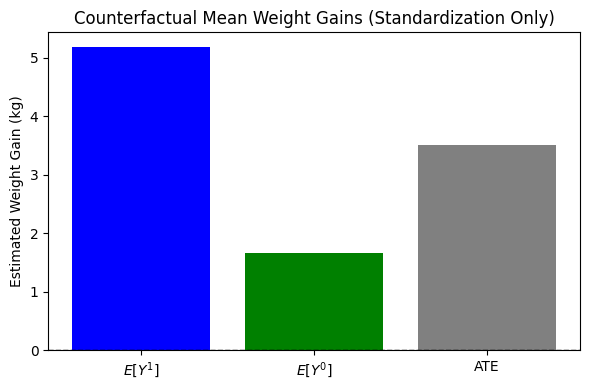

In [3]:
import matplotlib.pyplot as plt

params = ["$E[Y^1]$", "$E[Y^0]$", "ATE"]
values = [mean_treated, mean_untreated, causal_effect]

plt.figure(figsize=(6, 4))
plt.bar(params, values, color=["blue", "green", "gray"])
plt.ylabel("Estimated Weight Gain (kg)")
plt.title("Counterfactual Mean Weight Gains (Standardization Only)")
plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.tight_layout()
plt.show()

### Q2: Obtain standard errors and confidence intervals for the counterfactual means and the average causal treatment effect estimated in Q1 using the `emmeans` package

- **a** - Use the function:
```r
emmeans(fm, "f_qsmk", counterfactuals = "f_qsmk", data = XXXX, vcov. = sandwich::vcovHC(fm, type = "HC0"))
```
where `fm` is a fitted model object to estimate standard errors and confidence intervals for the counterfactual means. Note that the arguments `data` and `vcov.` are optional. Choose an appropriate dataset defining the confounder distribution on which to standardize.

- **b** - Explain which counterfactual means are estimated in terms of:

- $E[Y^{a=1}, C=0]$
- $E[Y^{a=0}, C=0]$

That is, the expected outcomes under treatment ($a=1$) and no treatment ($a=0$), standardized to the observed covariate distribution among uncensored individuals ($C=0$).

In [4]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from scipy.stats import norm

# Load full dataset (df), then filter when needed
df = load_nhefs()

# Fit model helper
def fit_model(df_unc, cont_vars, cat_vars):
    df_unc = df_unc.copy()
    df_unc["smokeintensity_x_qsmk"] = df_unc["smokeintensity"] * df_unc["qsmk"]

    X_cont = df_unc[cont_vars]
    X_cat = pd.get_dummies(df_unc[cat_vars], drop_first=True)
    X_int = df_unc[["smokeintensity_x_qsmk"]]
    X_treat = df_unc[["qsmk"]]

    X_train = pd.concat([X_treat, X_cont, X_cat, X_int], axis=1)
    X_train = sm.add_constant(X_train).astype(float)
    y = df_unc["wt82_71"]

    model = sm.OLS(y, X_train).fit(cov_type="HC0")
    return model, X_train.columns

# Build design matrix helper
def build_design_matrix(df_input, qsmk_val, X_ref_cols):
    df_temp = df_input.copy()
    df_temp["qsmk"] = qsmk_val
    df_temp["smokeintensity_x_qsmk"] = df_temp["smokeintensity"] * qsmk_val

    X = pd.concat([
        pd.Series(qsmk_val, index=df_temp.index, name="qsmk"),
        df_temp[cont_vars],
        pd.get_dummies(df_temp[cat_vars], drop_first=True),
        df_temp[["smokeintensity_x_qsmk"]]
    ], axis=1)

    X = sm.add_constant(X).astype(float)
    return X.reindex(columns=X_ref_cols, fill_value=0)

# --- Q2 Start ---

df_unc = df[df["wt82"].notna()]
model, X_train_cols = fit_model(df_unc, cont_vars, cat_vars)

pred_treated = model.get_prediction(build_design_matrix(df, 1, X_train_cols))
pred_untreated = model.get_prediction(build_design_matrix(df, 0, X_train_cols))

treated_df = pred_treated.summary_frame(alpha=0.05)
untreated_df = pred_untreated.summary_frame(alpha=0.05)

mean_treated = treated_df["mean"].mean()
se_treated = treated_df["mean_se"].mean()
mean_untreated = untreated_df["mean"].mean()
se_untreated = untreated_df["mean_se"].mean()

ate = mean_treated - mean_untreated
se_ate = np.sqrt(se_treated**2 + se_untreated**2)

z = norm.ppf(0.975)
ci_treated = (mean_treated - z * se_treated, mean_treated + z * se_treated)
ci_untreated = (mean_untreated - z * se_untreated, mean_untreated + z * se_untreated)
ci_ate = (ate - z * se_ate, ate + z * se_ate)

# Output
print("Q2: Standard errors via HC0 (emmeans equivalent)")
print(f"E[Y^1, C=0] = {mean_treated:.2f} (95% CI: {ci_treated[0]:.2f}, {ci_treated[1]:.2f})")
print(f"E[Y^0, C=0] = {mean_untreated:.2f} (95% CI: {ci_untreated[0]:.2f}, {ci_untreated[1]:.2f})")
print(f"ATE         = {ate:.2f} (95% CI: {ci_ate[0]:.2f}, {ci_ate[1]:.2f})")

Q2: Standard errors via HC0 (emmeans equivalent)
E[Y^1, C=0] = 6.77 (95% CI: -2.72, 16.25)
E[Y^0, C=0] = 1.66 (95% CI: 0.06, 3.26)
ATE         = 5.11 (95% CI: -4.51, 14.72)


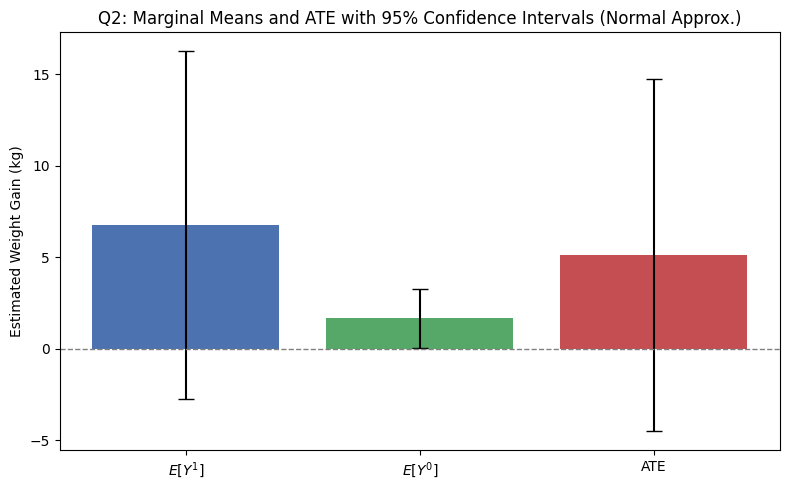

In [5]:
import matplotlib.pyplot as plt

# Estimates and intervals
labels = ["$E[Y^1]$", "$E[Y^0]$", "ATE"]
means = [mean_treated, mean_untreated, ate]
lower_bounds = [ci_treated[0], ci_untreated[0], ci_ate[0]]
upper_bounds = [ci_treated[1], ci_untreated[1], ci_ate[1]]
errors = [
    [mean - low for mean, low in zip(means, lower_bounds)],
    [up - mean for mean, up in zip(means, upper_bounds)]
]

# Plot
x = np.arange(len(labels))
fig, ax = plt.subplots(figsize=(8, 5))

ax.bar(x, means, yerr=errors, capsize=6, color=["#4c72b0", "#55a868", "#c44e52"])
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylabel("Estimated Weight Gain (kg)")
ax.set_title("Q2: Marginal Means and ATE with 95% Confidence Intervals (Normal Approx.)")
ax.axhline(0, color='gray', linestyle='--', linewidth=1)

plt.tight_layout()
plt.show()

### Q3: Obtain standard errors and confidence intervals for the counterfactual means and the average causal treatment effect estimated in Q1 using the bootstrap

- Resample the rows of the dataset (**which dataset?**) with replacement and fit the linear regression model to obtain estimates of the counterfactual means and the average causal effect.
- Use $B = 1000$ bootstrap replicates (or as many as your programming skills and patience allow).
- Estimate the standard errors of the three counterfactual parameters:
  - $E[Y^{a=1}, C=0]$
  - $E[Y^{a=0}, C=0]$
  - $E[Y^{a=1}, C=0] - E[Y^{a=0}, C=0]$
- Compute 95% confidence intervals and present the results in a small table.
- Compare the bootstrap results to those obtained from the `emmeans` package in the previous question. For this comparison, use:
  1. The “HC0”-type robust standard errors
  2. The default “HC3”-type robust standard errors  
     (`vcov. = sandwich::vcovHC(fm, type = "HC3")` or simply `vcov. = sandwich::vcovHC`)
  3. The unadjusted standard errors obtained by omitting the `vcov.` argument

- **Question**: Which type of unadjusted or robust standard errors is preferable if you don’t want to go all the way to bootstrap standard errors?


In [6]:
import pandas as pd
from tqdm import trange

# Load full dataset
df = load_nhefs()
df_unc = df[df["wt82"].notna()]

# Setup
B = 1000
boot_results = []

# Bootstrap loop
for _ in trange(B, desc="Bootstrapping"):
    # Resample uncensored individuals with replacement
    sample = df_unc.sample(n=len(df_unc), replace=True)

    # Fit model and get training columns
    try:
        model_b, X_cols = fit_model(sample, cont_vars, cat_vars)

        # Predict counterfactuals over full df
        pred1 = model_b.predict(build_design_matrix(df, 1, X_cols)).mean()
        pred0 = model_b.predict(build_design_matrix(df, 0, X_cols)).mean()
        boot_results.append((pred1, pred0, pred1 - pred0))

    except Exception as e:
        continue  # skip failed replicates silently

# Convert to DataFrame
boot_df = pd.DataFrame(boot_results, columns=["E_Y1", "E_Y0", "ATE"])

# Compute statistics
summary = boot_df.agg(["mean", "std"])
summary.loc["lower"] = boot_df.quantile(0.025)
summary.loc["upper"] = boot_df.quantile(0.975)

print("Q3: Bootstrap Percentile Confidence Intervals")
print(summary.round(3))

Bootstrapping: 100%|██████████| 1000/1000 [00:28<00:00, 34.51it/s]

Q3: Bootstrap Percentile Confidence Intervals
         E_Y1   E_Y0     ATE
mean    6.607  1.675   4.932
std     4.707  0.205   4.699
lower  -2.652  1.259  -4.177
upper  15.639  2.071  13.877


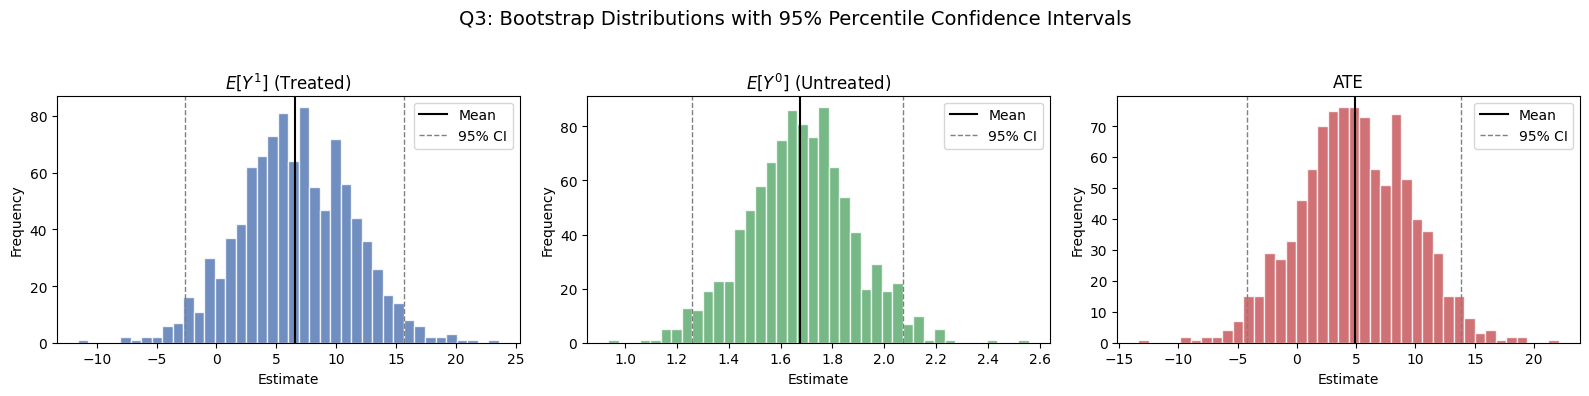

In [7]:
import matplotlib.pyplot as plt

# Bootstrap estimates
params = ["E_Y1", "E_Y0", "ATE"]
titles = ["$E[Y^1]$ (Treated)", "$E[Y^0]$ (Untreated)", "ATE"]
colors = ["#4c72b0", "#55a868", "#c44e52"]

fig, axes = plt.subplots(1, 3, figsize=(16, 4), sharey=False)

for i, param in enumerate(params):
    ax = axes[i]
    samples = boot_df[param]
    mean_val = samples.mean()
    lower, upper = samples.quantile([0.025, 0.975])

    # Histogram
    ax.hist(samples, bins=40, color=colors[i], edgecolor='white', alpha=0.8)
    ax.axvline(mean_val, color='black', linestyle='-', linewidth=1.5, label='Mean')
    ax.axvline(lower, color='gray', linestyle='--', linewidth=1, label='95% CI')
    ax.axvline(upper, color='gray', linestyle='--', linewidth=1)
    ax.set_title(titles[i])
    ax.set_xlabel("Estimate")
    ax.set_ylabel("Frequency")
    ax.legend()

fig.suptitle("Q3: Bootstrap Distributions with 95% Percentile Confidence Intervals", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

### Q4: Use the bootstrap-*t* method (cf. <a href="https://pubmed.ncbi.nlm.nih.gov/27019512/">Hesterberg 2014</a>) to obtain a more precise 95% CI

I have discussed the bootstrap-*t* method with most (though not all) of you. If you feel up for the challenge, try the bootstrap-*t* method (cf. <a href="https://arxiv.org/abs/1411.5279?utm_source=chatgpt.com">Hesterberg 2014</a>) to obtain even more accurate 95% confidence intervals for the parameters.

The bootstrap-*t* method improves confidence interval accuracy by accounting for variability in both the estimates and their standard errors.

For each bootstrap sample, compute:

$$
t_b = \frac{\hat\theta_b - \hat\theta}{\text{SE}_b}
$$

Then use the empirical quantiles of the $t_b$ distribution to construct the confidence interval:

$$
\hat\theta \pm t^* \cdot \text{SE}_{\hat\theta}
$$

This method typically yields more accurate 95% confidence intervals than the percentile method, especially in small samples or when the estimator is skewed or heteroskedastic.

| Method        | How It Works                                                            | Assumes Constant SE? | Symmetric? | Accuracy (Small $n$) |
| ------------- | ----------------------------------------------------------------------- | -------------------- | ---------- | ---------------------- |
| Percentile    | Uses percentiles of $\hat\theta_b$                                   | ✅ Yes                | ❌ Maybe    | ❌ Less reliable        |
| Bootstrap-*t* | Uses percentiles of $t_b = \frac{\hat\theta_b - \hat\theta}{SE_b}$ | ❌ No                 | ✅ Better   | ✅ More robust          |


In [8]:
import pandas as pd
import numpy as np
from tqdm import trange

# Load full data and subset uncensored for modeling
df = load_nhefs()
df_unc = df[df["wt82"].notna()]

# Fit the reference model once
model, X_train_cols = fit_model(df_unc, cont_vars, cat_vars)

# Compute original estimates and SEs
def point_se(model, df_input, treat_val, X_cols):
    X = build_design_matrix(df_input, treat_val, X_cols)
    pred = model.get_prediction(X)
    return pred.predicted_mean.mean(), pred.se_mean.mean()

theta_1, se_1 = point_se(model, df, 1, X_train_cols)
theta_0, se_0 = point_se(model, df, 0, X_train_cols)
theta_ate = theta_1 - theta_0
se_ate = np.sqrt(se_1**2 + se_0**2)

# Bootstrap-t
B = 1000
t_vals = {"E_Y1": [], "E_Y0": [], "ATE": []}

for _ in trange(B, desc="Bootstrap-t"):
    sample = df_unc.sample(n=len(df_unc), replace=True)

    try:
        model_b, Xb_cols = fit_model(sample, cont_vars, cat_vars)
        b1, se_b1 = point_se(model_b, df, 1, Xb_cols)
        b0, se_b0 = point_se(model_b, df, 0, Xb_cols)
        bate = b1 - b0
        se_bate = np.sqrt(se_b1**2 + se_b0**2)

        t_vals["E_Y1"].append((b1 - theta_1) / se_b1)
        t_vals["E_Y0"].append((b0 - theta_0) / se_b0)
        t_vals["ATE"].append((bate - theta_ate) / se_bate)

    except:
        continue

# Construct confidence intervals from bootstrap t-values
alpha = 0.05
ci_dict = {}
estimates = {"E_Y1": theta_1, "E_Y0": theta_0, "ATE": theta_ate}
standard_errors = {"E_Y1": se_1, "E_Y0": se_0, "ATE": se_ate}

for param in estimates:
    t_dist = np.array(t_vals[param])
    q_low, q_high = np.quantile(t_dist, [1 - alpha/2, alpha/2])
    est, se = estimates[param], standard_errors[param]
    ci = (est - q_low * se, est - q_high * se)

    ci_dict[param] = {
        "estimate": round(est, 2),
        "lower": round(ci[0], 2),
        "upper": round(ci[1], 2),
    }

# Output
print("\nQ4: Bootstrap-t 95% Confidence Intervals")
for k, v in ci_dict.items():
    print(f"{k:6}: {v['estimate']} (95% CI: {v['lower']}, {v['upper']})")

Bootstrap-t: 100%|██████████| 1000/1000 [00:32<00:00, 30.46it/s]


Q4: Bootstrap-t 95% Confidence Intervals
E_Y1  : 6.77 (95% CI: -2.14, 15.91)
E_Y0  : 1.66 (95% CI: 1.27, 2.08)
ATE   : 5.11 (95% CI: -3.72, 14.45)


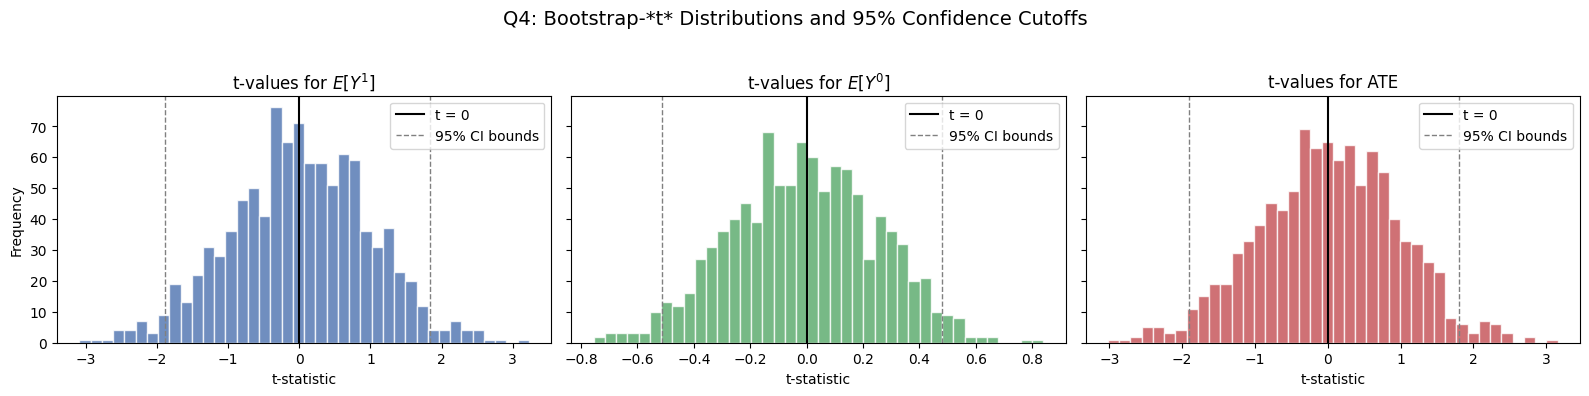

In [9]:
import matplotlib.pyplot as plt

# Parameters
params = ["E_Y1", "E_Y0", "ATE"]
titles = ["t-values for $E[Y^1]$", "t-values for $E[Y^0]$", "t-values for ATE"]
colors = ["#4c72b0", "#55a868", "#c44e52"]

fig, axes = plt.subplots(1, 3, figsize=(16, 4), sharey=True)

for i, param in enumerate(params):
    ax = axes[i]
    t_vals_array = np.array(t_vals[param])
    lower, upper = np.quantile(t_vals_array, [0.025, 0.975])

    ax.hist(t_vals_array, bins=40, color=colors[i], edgecolor='white', alpha=0.8)
    ax.axvline(0, color='black', linestyle='-', linewidth=1.5, label='t = 0')
    ax.axvline(lower, color='gray', linestyle='--', linewidth=1, label='95% CI bounds')
    ax.axvline(upper, color='gray', linestyle='--', linewidth=1)

    ax.set_title(titles[i])
    ax.set_xlabel("t-statistic")
    if i == 0:
        ax.set_ylabel("Frequency")
    ax.legend()

fig.suptitle("Q4: Bootstrap-*t* Distributions and 95% Confidence Cutoffs", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


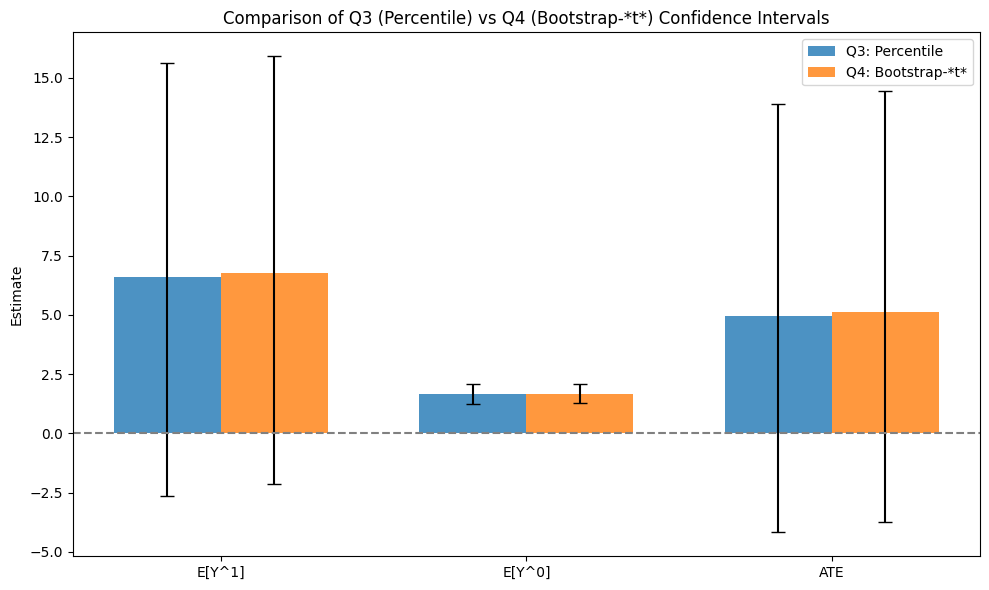

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# Setup
params = ["E[Y^1]", "E[Y^0]", "ATE"]
x = np.arange(len(params))
width = 0.35

# Get Q3 (percentile) stats
q3_labels = ["E_Y1", "E_Y0", "ATE"]
q3_means = boot_df[q3_labels].mean().values
q3_lowers = boot_df[q3_labels].quantile(0.025).values
q3_uppers = boot_df[q3_labels].quantile(0.975).values

# Get Q4 (bootstrap-t) stats
q4_means = [ci_dict[k]["estimate"] for k in q3_labels]
q4_lowers = [ci_dict[k]["lower"] for k in q3_labels]
q4_uppers = [ci_dict[k]["upper"] for k in q3_labels]

# Calculate error bars
q3_errs = [
    [mean - low for mean, low in zip(q3_means, q3_lowers)],
    [up - mean for mean, up in zip(q3_means, q3_uppers)]
]

q4_errs = [
    [mean - low for mean, low in zip(q4_means, q4_lowers)],
    [up - mean for mean, up in zip(q4_means, q4_uppers)]
]

# Plot
fig, ax = plt.subplots(figsize=(10, 6))

ax.bar(x - width/2, q3_means, width, label="Q3: Percentile", color="#1f77b4", alpha=0.8,
       yerr=q3_errs, capsize=5)
ax.bar(x + width/2, q4_means, width, label="Q4: Bootstrap-*t*", color="#ff7f0e", alpha=0.8,
       yerr=q4_errs, capsize=5)

ax.axhline(0, linestyle='--', color='gray')
ax.set_xticks(x)
ax.set_xticklabels(params)
ax.set_ylabel("Estimate")
ax.set_title("Comparison of Q3 (Percentile) vs Q4 (Bootstrap-*t*) Confidence Intervals")
ax.legend()

plt.tight_layout()
plt.show()

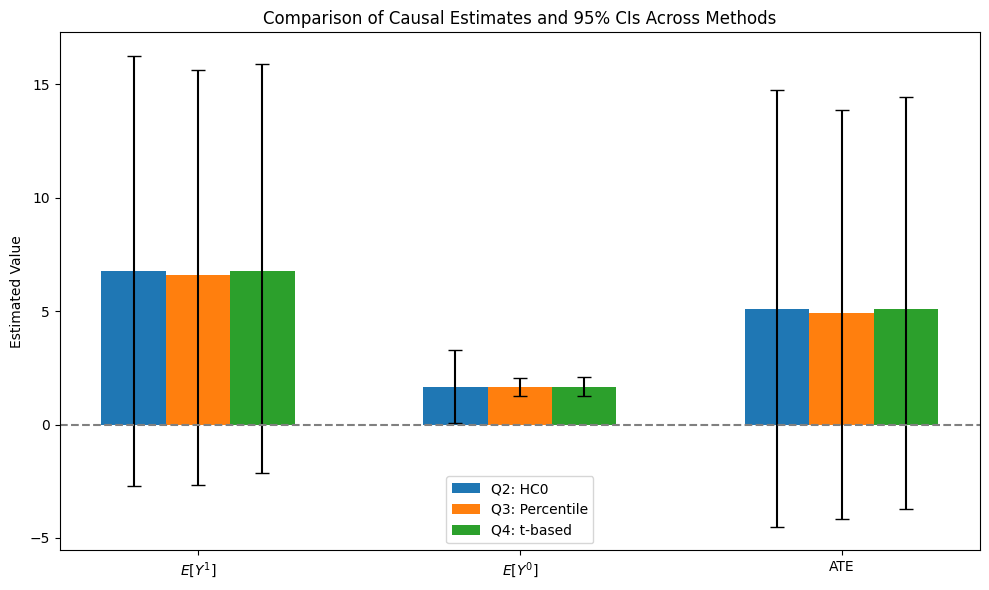

In [11]:
methods = ["Q2: HC0", "Q3: Percentile", "Q4: t-based"]
params = ["$E[Y^1]$", "$E[Y^0]$", "ATE"]

# Q2
q2_means = [mean_treated, mean_untreated, ate]
q2_lowers = [ci_treated[0], ci_untreated[0], ci_ate[0]]
q2_uppers = [ci_treated[1], ci_untreated[1], ci_ate[1]]

# Q3
q3_means = boot_df.mean()[q3_labels].tolist()
q3_cis = boot_df[q3_labels].quantile([0.025, 0.975])
q3_lowers = q3_cis.loc[0.025].tolist()
q3_uppers = q3_cis.loc[0.975].tolist()

# Q4
q4_labels = ["E_Y1", "E_Y0", "ATE"]
q4_means = [ci_dict[k]["estimate"] for k in q4_labels]
q4_lowers = [ci_dict[k]["lower"] for k in q4_labels]
q4_uppers = [ci_dict[k]["upper"] for k in q4_labels]

# Combine for plotting
bar_data = [q2_means, q3_means, q4_means]
error_lows = [[m - l for m, l in zip(method, lows)] for method, lows in zip(bar_data, [q2_lowers, q3_lowers, q4_lowers])]
error_upps = [[u - m for m, u in zip(method, upps)] for method, upps in zip(bar_data, [q2_uppers, q3_uppers, q4_uppers])]

# Plot
x = np.arange(len(params))
width = 0.2

fig, ax = plt.subplots(figsize=(10, 6))

for i in range(3):
    offset = (i - 1) * width
    ax.bar(x + offset, bar_data[i], width, label=methods[i])
    ax.errorbar(x + offset, bar_data[i], 
                yerr=[error_lows[i], error_upps[i]], fmt='none', capsize=5, ecolor='black')

ax.set_xticks(x)
ax.set_xticklabels(params)
ax.axhline(0, linestyle='--', color='gray')
ax.set_ylabel("Estimated Value")
ax.set_title("Comparison of Causal Estimates and 95% CIs Across Methods")
ax.legend()

plt.tight_layout()
plt.show()


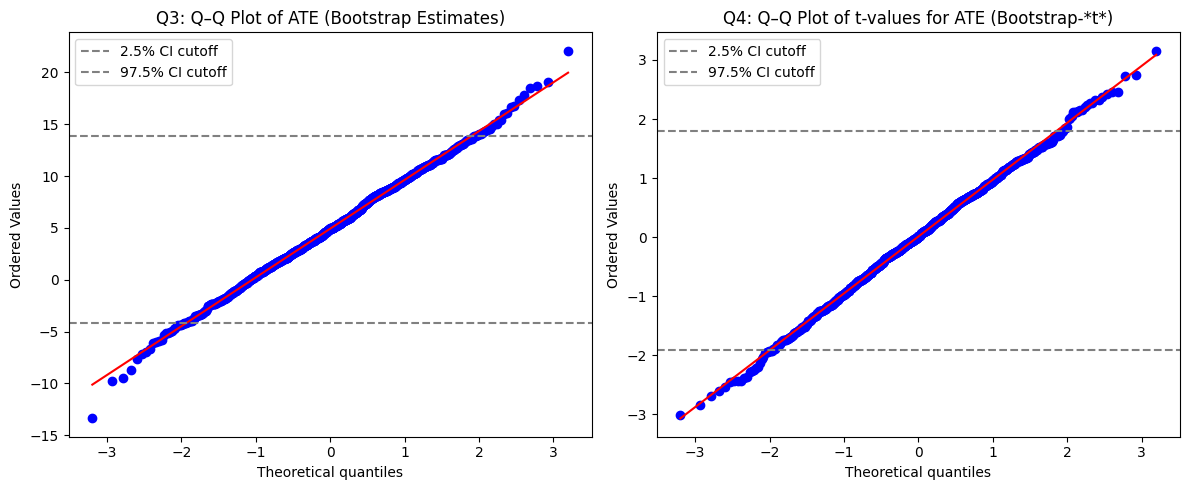

In [12]:
import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Q3: ATE bootstrap estimates vs normal
stats.probplot(boot_df["ATE"], dist="norm", plot=axes[0])
q3_025, q3_975 = np.quantile(boot_df["ATE"], [0.025, 0.975])
axes[0].axhline(q3_025, linestyle='--', color='gray', label='2.5% CI cutoff')
axes[0].axhline(q3_975, linestyle='--', color='gray', label='97.5% CI cutoff')
axes[0].set_title("Q3: Q–Q Plot of ATE (Bootstrap Estimates)")
axes[0].legend()

# Q4: t-values for ATE vs standard normal
stats.probplot(t_vals["ATE"], dist="norm", plot=axes[1])
t_025, t_975 = np.quantile(t_vals["ATE"], [0.025, 0.975])
axes[1].axhline(t_025, linestyle='--', color='gray', label='2.5% CI cutoff')
axes[1].axhline(t_975, linestyle='--', color='gray', label='97.5% CI cutoff')
axes[1].set_title("Q4: Q–Q Plot of t-values for ATE (Bootstrap-*t*)")
axes[1].legend()

plt.tight_layout()
plt.show()